# Time-Accurate BET eVTOL Simulation Example

This notebook sets up a time-accurate simulation of a **BET ([Blade Element Theory](https://docs.flexcompute.com/projects/flow360/en/latest/capabilities/propellerModelsRotationalVolumeZones/propellerModelsRotationalVolumeZones.html#blade-element-theory-disk-bet-disk "BET documentation") ) eVTOL** using the Flow360 Python API.

![image](figures/bet_evtol_with_refinement_boxes.png)


The setup demonstrates how to:
* Load geometry from an example library.
* Define custom geometric entities for refinement zones.
* Set up an unsteady (time-accurate) simulation using the Spalart-Allmaras DDES turbulence model.
* Incorporate the BETLine model to represent the propellers in a time accuraet fashion.

## 1. Imports and Project Setup

First, we import the necessary Flow360 libraries and the specific `BETEVTOL` example module to retrieve the geometry and BET disk configuration files. We then create a new project and upload the geometry to the Flow360 cloud.

In [1]:
import flow360 as fl
from flow360.examples import BETEVTOL

# Fetch all necessary files (geometry, BET disk data, etc.)
BETEVTOL.get_files()

# Create the project from the BET eVTOL example geometry
project = fl.Project.from_geometry(BETEVTOL.geometry, name="BET eVTOL")

# Get the geometry object for configuration
geometry = project.geometry

# Group all edges and faces by their tags for simple reference later ('*' selects all entities)
geometry.group_edges_by_tag("edgeId")
geometry.group_faces_by_tag("faceId")

Output()

[07:35:37] INFO: Geometry successfully submitted:                                                                  
                   type        = Geometry                                                                          
                   name        = BET eVTOL                                                                         
                   id          = geo-84ea4b8a-74e3-42e9-aef4-e27bdfbee250                                          
                   status      = uploaded                                                                          
                   project id  = prj-f913bbc9-e28f-4792-a936-67d84cb58450                                          
           

           INFO: Waiting for geometry to be processed.

Output()

[07:36:27] INFO: Regrouping face entities under `faceId` tag (previous `faceName`).

--- 
## 2. Define Refinement Entities and Slice Outputs

We define the geometric entities that will be used to control the mesh refinement around the eVTOL body and the BET propellers. We also define cross-sectional slices for flow visualization post-processing. All entities are defined within the `SI_unit_system` context for consistency.

In [2]:
with fl.SI_unit_system:
    # Define two nested boxes for uniform volumetric refinement around the body
    box1 = fl.Box(name="Box 1", center=[2, 0, 0.5], size=[12, 16, 4])
    box2 = fl.Box(name="Box 2", center=[8, 0, 0.5], size=[24, 32, 8])

    # Define eight cylindrical zones for axisymmetric refinement around the BET propellers
    cylinder1 = fl.Cylinder(
        name="BET 1",
        center=[-1.95, -6, 0.57],
        axis=[-1, 0, 0],
        outer_radius=1.5,
        height=0.2,
    )
    cylinder2 = fl.Cylinder(
        name="BET 2",
        center=[-1.95, -2.65, 0.51],
        axis=[-1, 0, 0],
        outer_radius=1.5,
        height=0.2,
    )
    cylinder3 = fl.Cylinder(
        name="BET 3",
        center=[-1.95, 2.65, 0.51],
        axis=[-1, 0, 0],
        outer_radius=1.5,
        height=0.2,
    )
    cylinder4 = fl.Cylinder(
        name="BET 4",
        center=[-1.95, 6, 0.57],
        axis=[-1, 0, 0],
        outer_radius=1.5,
        height=0.2,
    )
    cylinder5 = fl.Cylinder(
        name="BET 5",
        center=[2.7, -6, 1.06],
        axis=[0, 0, 1],
        outer_radius=1.5,
        height=0.2,
    )
    cylinder6 = fl.Cylinder(
        name="BET 6",
        center=[2.7, -2.65, 1.06],
        axis=[0, 0, 1],
        outer_radius=1.5,
        height=0.2,
    )
    cylinder7 = fl.Cylinder(
        name="BET 7",
        center=[2.7, 2.65, 1.06],
        axis=[0, 0, 1],
        outer_radius=1.5,
        height=0.2,
    )
    cylinder8 = fl.Cylinder(
        name="BET 8",
        center=[2.7, 6, 1.06],
        axis=[0, 0, 1],
        outer_radius=1.5,
        height=0.2,
    )

    # Define slices for flow field output along the BET locations
    slices = [
        fl.Slice(name=f"Slice BET {i+1}", normal=[0, 1, 0], origin=[0, originY, 0])
        for i, originY in enumerate([-6, -2.65, 2.65, 6])
    ]

    # Define the automated farfield boundary
    farfield = fl.AutomatedFarfield(name="Farfield")

[07:36:28] INFO: using: SI unit system for unit inference.

--- 
## 3. Configure Meshing Parameters

We specify the details for the mesh generation, including boundary layer settings and the application of the previously defined refinement entities.

In [3]:
with fl.SI_unit_system:
    meshing_params = fl.MeshingParams(
        defaults=fl.MeshingDefaults(
            # Global surface meshing and boundary layer thickness
            surface_max_edge_length=0.05,
            boundary_layer_first_layer_thickness=0.01 * fl.u.mm,
        ),
        volume_zones=[farfield],  # Use the automated farfield boundary
        refinements=[
            # Axisymmetric refinement for the BET zones
            fl.AxisymmetricRefinement(
                name="BET refinement",
                spacing_axial=0.01,
                spacing_radial=0.03,
                spacing_circumferential=0.03,
                entities=[
                    cylinder1,
                    cylinder2,
                    cylinder3,
                    cylinder4,
                    cylinder5,
                    cylinder6,
                    cylinder7,
                    cylinder8,
                ],
            ),
            # Uniform refinements for the inner (Box 1) and outer (Box 2) regions
            fl.UniformRefinement(
                name="Uniform refinement 0.05", spacing=0.05, entities=box1
            ),
            fl.UniformRefinement(
                name="Uniform refinement 0.1", spacing=0.1, entities=box2
            ),
        ],
    )

           INFO: using: SI unit system for unit inference.

--- 
## 4. Define Boundary Conditions and Physics Models

We define the reference geometry, flight conditions, and the physics models for the simulation. This includes the turbulence model (Spalart-Allmaras DDES) and the four BETDisk models to replicate the propellers. Note that since we are doing a time accurate simulation, they are now called BETLine.

In [4]:
with fl.SI_unit_system:
    # Reference properties for force and moment coefficients
    ref_geo = fl.ReferenceGeometry(
        area=16.8, moment_center=[0, 0, 0], moment_length=[1.4, 1.4, 1.4]
    )

    # Operating flight condition: 70 m/s at 15 degrees angle of attack
    op_cond = fl.AerospaceCondition(velocity_magnitude=70, alpha=15 * fl.u.deg)

    # Fluid model with DDES turbulence closure for unsteady accuracy
    fluid_model = fl.Fluid(
        navier_stokes_solver=fl.NavierStokesSolver(relative_tolerance=0.01),
        turbulence_model_solver=fl.SpalartAllmaras(
            relative_tolerance=0.01,
            rotation_correction=True,
            hybrid_model=fl.DetachedEddySimulation(),  # DDES for accurate flow separation
        ),
    )

    # Define physics models including
    models_list = [
        fl.Wall(name="Wall", surfaces=[geometry["*"]]),
        fl.Freestream(name="Freestream", surfaces=[farfield.farfield]),
        fluid_model,
    ]

           INFO: using: SI unit system for unit inference.

# Add the BET disks to the models list

the `BETDisk` class has a wide variety of ways of giving the code the propeller information (twist and chord distributions, airfoil data, operating conditions, etc) it needs. For more information on the `BETDisk` class please see the [BETDisk documentation](https://docs.flexcompute.com/projects/flow360/en/latest/python/api/_autosummary/flow360.BETDisk.html#flow360.BETDisk).
For more information on the BET model in Flow360 please see the [BET documentation](https://docs.flexcompute.com/projects/flow360/en/latest/capabilities/propellerModelsRotationalVolumeZones/propellerModelsRotationalVolumeZones.html#blade-element-theory-disk-bet-disk).

In this example we use the `from_file` method to load all of the necessary information from the example files provided in the `BETEVTOL` module.

The BETEVTOL class contains the URLs to download the geometry and the BET disk files. Our example EVTOL has 8 propellers grouped in symmetrical pairs: 1&3, 2&4, 5&7, and 6&8. Each pair uses the same BET disk file, so we only need to load 4 unique BET disks definitions.

The BETEVTOL.extra["diskXY"] calls are simply accessing the files for the diskXY example files stored in the `BETEVTOL` class.

This could also be done by providing the file paths directly to the `from_file` method if the files were stored locally.

So here we load the four unique BET disks from the example files and append them to the `models_list` created above.



In [5]:
# Append The four BET disks loaded from the example files to the models_list
models_list.append(fl.BETDisk.from_file(BETEVTOL.extra["disk13"]))
models_list.append(fl.BETDisk.from_file(BETEVTOL.extra["disk24"]))
models_list.append(fl.BETDisk.from_file(BETEVTOL.extra["disk57"]))
models_list.append(fl.BETDisk.from_file(BETEVTOL.extra["disk68"]))

--- 
## 5. Configure Time Stepping and Outputs

Since this is a time-accurate simulation, we specify the `Unsteady` time-stepping settings, including the time step size and the adaptive CFL number control. We also define the desired output fields for surfaces and slices.

In [6]:
with fl.SI_unit_system:
    # Unsteady time marching parameters
    time_model = fl.Unsteady(
        steps=1000,
        step_size=0.0004,
        max_pseudo_steps=30,  # Max inner iterations per physical time step
        CFL=fl.AdaptiveCFL(
            min=1, max=3000, max_relative_change=50, convergence_limiting_factor=0.1
        ),
    )

    # Define desired output fields
    outputs_list = [
        fl.SurfaceOutput(
            name="Surface output",
            output_fields=[
                "Cp",
                "yPlus",
                "Cf",
                "CfVec",
            ],  # Pressure, wall spacing, skin friction
            surfaces=[geometry["*"]],
        ),
        fl.SliceOutput(
            name="Slice output",
            output_fields=["Cp", "Mach", "vorticity"],
            slices=[*slices],  # Uses the slices defined in section 2
        ),
    ]

[07:36:29] INFO: using: SI unit system for unit inference.

--- 
## 6. Construct Final Simulation Parameters

The sub-components defined in the previous steps are combined into the single final `SimulationParams` object, which holds all the configuration data.

In [7]:
with fl.SI_unit_system:
    params = fl.SimulationParams(
        meshing=meshing_params,
        reference_geometry=ref_geo,
        operating_condition=op_cond,
        models=models_list,
        time_stepping=time_model,
        outputs=outputs_list,
    )

           INFO: using: SI unit system for unit inference.

--- 
## 7. Run the Case

Submit the case to the Flow360 cloud using the defined parameters. The solver will now proceed with meshing and then the time-accurate fluid simulation.

In [8]:
case = project.run_case(params, name="BET eVTOL case")

           INFO: using: SI unit system for unit inference.

[07:36:31] INFO: Successfully submitted:                                                                           
                   type        = Case                                                                              
                   name        = BET eVTOL case                                                                    
                   id          = case-62f2cfff-cd08-462a-bc26-37ba64b7ecc7                                         
                   status      = pending                                                                           
                   project id  = prj-f913bbc9-e28f-4792-a936-67d84cb58450                                          
           

While we wait for the case to finish, we invite you to monitor the case in the Flow360 GUI. Once finished, you can easily post-process the results after completion.






Output()

Output()

[08:29:08] INFO: Saved to C:\Users\user\AppData\Local\Temp\tmp4klip3t7\b0b3926f-4e92-4d46-a47b-c12642e68009.csv

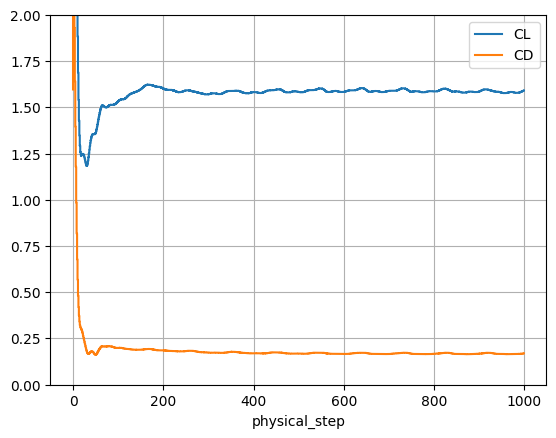

In [9]:
# wait until the case finishes execution
case.wait()

results = case.results

# total forces contain the CL and CD history
total_forces = case.results.total_forces.as_dataframe()
ax = total_forces.plot("physical_step", ["CL", "CD"], ylim=(0, 2))
ax.grid(True)

You can also look at the results in the Flow360 GUI.

![GUI_image](figures/bet_evtol_surface_view.png)